# Definition of the main class for all addition tasks #

In [70]:
from encodings.idna import sace_prefix

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from scipy.optimize import minimize
from matplotlib.lines import Line2D

# --------------------------- storage bundle ----------------------------------
@dataclass
class RunArtifacts:
    rep: str
    center: str
    N: int
    # digits
    a_tr: np.ndarray
    b_tr: np.ndarray
    a_te: np.ndarray
    b_te: np.ndarray
    # features (no bias)
    F_tr: np.ndarray
    F_te: np.ndarray
    mu: Optional[np.ndarray]  # training feature mean if center=='train', else None
    # with/without bias
    X_tr: np.ndarray
    X_te: np.ndarray
    # targets
    y_tr: np.ndarray
    y_te: np.ndarray
    y_train_mean: Optional[float]
    # Gram matrices
    Gram_F: np.ndarray
    Gram_F_norm: np.ndarray
    Gram_X: np.ndarray
    Gram_X_norm: np.ndarray
    # eigendecompositions (normalized Grams)
    eig_F_vals: np.ndarray
    eig_F_vecs: np.ndarray
    eig_X_vals: np.ndarray
    eig_X_vecs: np.ndarray
    # training penalty policy
    use_intercept: bool = False
    penalize_intercept: bool = False

# ------------------------------ simulator ------------------------------------
class AdditionRidgeTask:
    def __init__(
        self,
        *,
        lams: np.ndarray,
        N_values: List[int],
        N_test: int = 40_000,
        embed_dim: int = 10,
        center_E: bool = False,
        seed: Optional[int] = None,
        scale: Optional[float] = None,
        random_std: Optional[float] = 1,  # None → use default 1.0

    ):
        """
        If seed is None -> non-deterministic RNG & embedding.
        """
        self.lams = np.asarray(lams, dtype=float)
        self.N_values = [int(n) for n in N_values]
        self.N_test = int(N_test)
        self.embed_dim = int(embed_dim)
        self.seed = None if seed is None else int(seed)
        self.center_E = bool(center_E)
        self.random_std = 1.0 if random_std is None else float(random_std)
        self.scale = 1.0 if scale is None else float(scale)


        # RNG & random embedding table for the "random" representation
        self.rng = np.random.default_rng(self.seed)  # None -> nondeterministic
        E = self.rng.normal(loc=0.0, scale=self.random_std, size=(10, self.embed_dim))
        if self.center_E:
            E = E - E.mean(axis=0, keepdims=True)
        self.E = E / np.linalg.norm(E)

        if scale:
            self.E = self.E * scale

        self._artifacts: Dict[Tuple[str, str, int], RunArtifacts] = {}
        self._last_key: Optional[Tuple[str, str, int]] = None
    """
    Ridge regression on three feature representations (compact, onehot, random).
    Effective dimension: d_eff(λ) = Tr( G (G + λ P)^(-1) ), G=(1/N)X^T X, P=diag(pen_mask).
    """


    # ---------------------------- feature builders ----------------------------
    def _build_compact(self, a: np.ndarray, b: np.ndarray) -> np.ndarray:
        X = np.zeros((a.size, 20), dtype=float)
        X[:, 0]  = a
        X[:, 10] = b
        return X

    def _build_onehot_plain(self, a: np.ndarray, b: np.ndarray) -> np.ndarray:
        N = a.size
        X = np.zeros((N, 20), dtype=float)
        rows = np.arange(N)
        X[rows, a]      = 1.0
        X[rows, 10 + b] = 1.0
        return X

    def _build_onehot_fixed_centered(self, a: np.ndarray, b: np.ndarray) -> np.ndarray:
        # 0.9 at active index, -0.1 elsewhere (exactly centered under uniform digits)
        N = a.size
        X = np.full((N, 20), -0.1, dtype=float)
        rows = np.arange(N)
        X[rows, a]      += 1.0  # -> 0.9
        X[rows, 10 + b] += 1.0  # -> 0.9
        return X

    def _build_random(self, a: np.ndarray, b: np.ndarray) -> np.ndarray:
        return np.hstack([self.E[a], self.E[b]])

    def build_features(self, rep: str, a: np.ndarray, b: np.ndarray, center: str = "train"):
        rep = rep.lower(); center = center.lower()
        if rep == "compact":
            F = self._build_compact(a, b)
        elif rep == "onehot":
            F = self._build_onehot_fixed_centered(a, b) if center == "fixed" else self._build_onehot_plain(a, b)
        elif rep == "random":
            F = self._build_random(a, b)
        else:
            raise ValueError("rep must be one of {'compact','onehot','random'}")

        if center == "train":
            mu = F.mean(axis=0, keepdims=True)
            return F - mu, mu
        elif center in {"fixed", "none"}:
            return F, None
        else:
            raise ValueError("center must be 'train', 'fixed', or 'none'")

    # ---------------------------- targets & data ------------------------------
    def build_targets(self, a: np.ndarray, b: np.ndarray, center_mode: str, y_mean_train: Optional[float] = None):
        y_raw = (a + b).astype(float)
        c = center_mode.lower()
        if c in {"train", "fixed"}:
            m = float(y_raw.mean()) if y_mean_train is None else float(y_mean_train)
            return y_raw - m, m
        return y_raw, None

    def _draw_digits(self, N: int) -> Tuple[np.ndarray, np.ndarray]:
        return (self.rng.integers(0, 10, size=N), self.rng.integers(0, 10, size=N))

    # ---------------------------- numeric ridge -------------------------------
    @staticmethod
    def _half_mse(y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return 0.5 * np.mean((y_pred - y_true) ** 2)

    def run_numeric(self, rep: str, center: str = "none",
                    *, use_intercept: bool = False, penalize_intercept: bool = False,
                    method: str = "L-BFGS-B", maxiter: int = 10_000, tol: float = 1e-10) -> Dict[float, List[float]]:
        """
        Minimize TRAIN loss with built-in SciPy optimizer, evaluate TEST loss.
        Returns {λ: [loss at each N in self.N_values]}.
        """
        losses = {float(l): [] for l in self.lams}
        a_te_all, b_te_all = self._draw_digits(self.N_test)
        F_te_cache: Dict[str, np.ndarray] = {}

        for N in self.N_values:
            a_tr, b_tr = self._draw_digits(N)
            F_tr, mu = self.build_features(rep, a_tr, b_tr, center=center)

            if mu is not None:
                if "none" not in F_te_cache:
                    F_te_cache["none"], _ = self.build_features(rep, a_te_all, b_te_all, center="none")
                F_te = F_te_cache["none"] - mu
            else:
                if center not in F_te_cache:
                    F_te_cache[center], _ = self.build_features(rep, a_te_all, b_te_all, center=center)
                F_te = F_te_cache[center]

            y_tr, y_train_mean = self.build_targets(a_tr, b_tr, center_mode=center, y_mean_train=None)
            if y_train_mean is not None:
                y_te, _ = self.build_targets(a_te_all, b_te_all, center_mode=center, y_mean_train=y_train_mean)
            else:
                y_te, _ = self.build_targets(a_te_all, b_te_all, center_mode=center, y_mean_train=None)

            if use_intercept:
                X_tr = np.hstack([np.ones((N, 1)), F_tr])
                X_te = np.hstack([np.ones((self.N_test, 1)), F_te])
            else:
                X_tr = F_tr
                X_te = F_te

            p = X_tr.shape[1]
            pen_mask = np.ones(p, dtype=float)
            if use_intercept and not penalize_intercept:
                pen_mask[0] = 0.0
            P = np.diag(pen_mask)

            for lam in self.lams:
                lam = float(lam)
                def train_loss(w):
                    w = np.asarray(w)
                    res = X_tr @ w - y_tr
                    return 0.5 * np.mean(res**2) + 0.5 * lam * float(w.T @ (P @ w))
                w0 = np.zeros(p)
                opt = minimize(train_loss, w0, method=method, tol=tol, options={"maxiter": maxiter})
                w_hat = opt.x
                test_loss = 0.5 * np.mean((X_te @ w_hat - y_te) ** 2)
                losses[lam].append(float(test_loss))

            # diagnostics & storage
            XtX = X_tr.T @ X_tr
            Gram_F = F_tr.T @ F_tr
            Gram_F_norm = Gram_F / float(N)
            Gram_X = XtX
            Gram_X_norm = Gram_X / float(N)
            eig_F_vals, eig_F_vecs = np.linalg.eigh(Gram_F_norm)
            eig_X_vals, eig_X_vecs = np.linalg.eigh(Gram_X_norm)

            key = (rep.lower(), center.lower(), int(N))
            self._artifacts[key] = RunArtifacts(
                rep=rep.lower(), center=center.lower(), N=int(N),
                a_tr=a_tr, b_tr=b_tr, a_te=a_te_all, b_te=b_te_all,
                F_tr=F_tr, F_te=F_te, mu=mu,
                X_tr=X_tr, X_te=X_te,
                y_tr=y_tr, y_te=y_te,
                y_train_mean=(None if y_train_mean is None else float(y_train_mean)),
                Gram_F=Gram_F, Gram_F_norm=Gram_F_norm,
                Gram_X=Gram_X, Gram_X_norm=Gram_X_norm,
                eig_F_vals=eig_F_vals, eig_F_vecs=eig_F_vecs,
                eig_X_vals=eig_X_vals, eig_X_vecs=eig_X_vecs,
                use_intercept=bool(use_intercept),
                penalize_intercept=bool(penalize_intercept),
            )
            self._last_key = key

        return losses

    # ---------------------------- eigen retrieval -----------------------------
    def get_artifacts(self, rep: str, center: str, N: int) -> RunArtifacts:
        key = (rep.lower(), center.lower(), int(N))
        if key not in self._artifacts:
            raise KeyError(f"No artifacts for (rep={rep}, center={center}, N={N}). Run run_numeric first.")
        return self._artifacts[key]

    def get_eigs(
        self,
        rep: str,
        center: str,
        N: int,
        *,
        with_bias: bool = True,
        sort: str = "desc",
        eig_tol: float = 1e-12
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Fetch eigenpairs of the normalized Gram from a stored run.

        Args:
            with_bias: True -> eigs of (1/N) X^T X; False -> eigs of (1/N) F^T F.
            sort: 'desc' | 'asc' | 'none' (ordering of eigenvalues).
            eig_tol: relative trimming threshold; drops eigenvalues <= eig_tol * max(eigs).

        Returns:
            (evals, evecs) with shapes (d,), (d,d) after trimming and sorting.
        """
        art = self.get_artifacts(rep, center, N)
        evals = np.array(art.eig_X_vals if with_bias else art.eig_F_vals, dtype=float)
        evecs = np.array(art.eig_X_vecs if with_bias else art.eig_F_vecs, dtype=float)

        # numerical rank trimming
        if evals.size:
            thresh = eig_tol * max(1.0, float(np.max(evals)))
            keep = evals > thresh
            evals = evals[keep]
            evecs = evecs[:, keep]

        if sort == "desc":
            idx = np.argsort(evals)[::-1]
            evals, evecs = evals[idx], evecs[:, idx]
        elif sort == "asc":
            idx = np.argsort(evals)
            evals, evecs = evals[idx], evecs[:, idx]
        elif sort == "none":
            pass
        else:
            raise ValueError("sort must be one of {'desc','asc','none'}")

        return evals, evecs

    def get_gram(
        self,
        rep: str,
        center: str,
        N: int,
        *,
        with_bias: bool = True,
        normalized: bool = True
    ) -> np.ndarray:
        """
        Fetch the Gram matrix from a stored run.

        Args:
            with_bias: True -> Gram of X (includes intercept column if used);
                       False -> Gram of F (features without intercept).
            normalized: True -> returns (1/N) * Gram; False -> returns the raw Gram.

        Returns:
            np.ndarray: The requested Gram matrix.
        """
        art = self.get_artifacts(rep, center, N)
        if with_bias:
            return np.array(art.Gram_X_norm if normalized else art.Gram_X, dtype=float)
        else:
            return np.array(art.Gram_F_norm if normalized else art.Gram_F, dtype=float)


    # ---------------------------- analytic curves -----------------------------
    def run_analytic(self, rep: str, center: str = "none") -> Dict[float, List[float]]:
        """
        Analytic test loss curves for the noiseless, UNcentered case.

        - Compact (uncentered):
            L_test(λ) = (97.5/2) * ( λ / (48.75 + λ) )^2
        - One-hot (uncentered):
            L_test(λ) = (81/2) * ( λ / (0.2 + λ) )^2 + (16.5/2) * ( λ / (0.1 + λ) )^2
        - Random (uncentered):
            L_test(λ) = 0.5 * sum_k λ_k * ( λ / (λ_k + λ) )^2 * (u_k^T w_true)^2
              where {λ_k, u_k} are the eigenpairs of (1/N) X^T X for the stored run,
              and w_true is obtained by least-squares on the full 100 (a,b) pairs:
                  w_true = argmin_w ||X_full w - y_full||_2^2  (uncentered, no intercept).

        Returns:
            dict: {λ: [loss at each N in self.N_values]}
        """
        rep = rep.lower()
        center = center.lower()
        if center != "none":
            raise ValueError("run_analytic is defined here for the UNcentered ('none') case only.")

        losses = {float(l): [] for l in self.lams}

        # Closed-form cases (independent of N): repeat the same value per-N for interface parity
        if rep == "compact":
            for lam in self.lams:
                lam = float(lam)
                val = 0.5 * 97.5 * (lam / (48.75 + lam))**2
                losses[lam] = [float(val) for _ in self.N_values]
            return losses

        if rep == "onehot":
            for lam in self.lams:
                lam = float(lam)
                term1 = 0.5 * 81.0  * (lam / (0.2 + lam))**2
                term2 = 0.5 * 16.5 * (lam / (0.1 + lam))**2
                val = term1 + term2
                losses[lam] = [float(val) for _ in self.N_values]
            return losses

        if rep != "random":
            raise ValueError("rep must be one of {'compact','onehot','random'} for run_analytic().")

        # ---------------------- Random representation (general formula) ----------------------
        # Build a canonical (uncentered) full grid of all (a,b) pairs to compute w_true via LS.
        aa, bb = np.meshgrid(np.arange(10, dtype=int), np.arange(10, dtype=int), indexing="ij")
        a_full = aa.ravel()
        b_full = bb.ravel()
        F_full, _ = self.build_features("random", a_full, b_full, center="none")  # features without intercept
        X_full = F_full
        y_full, _ = self.build_targets(a_full, b_full, center_mode="none", y_mean_train=None)  # y = a+b

        # Least-squares "true" parameter (unregularized, uncentered)
        w_true, *_ = np.linalg.lstsq(X_full, y_full, rcond=None)
        w_true = np.asarray(w_true, dtype=float)

        # For each N, pull eigenpairs using the dedicated getter and evaluate the eigen-expansion.
        for N in self.N_values:
            evals, evecs = self.get_eigs("random", center, int(N), with_bias=True, sort="none", eig_tol=0.0)
            if evecs.shape[0] != w_true.size:
                raise ValueError(
                    f"Dim mismatch for N={N}: eigvecs are {evecs.shape[0]}-dim but w_true is {w_true.size}-dim. "
                    "Make sure run_numeric was invoked with use_intercept=False."
                )

            coeffs = evecs.T @ w_true  # shape: (d,)

            for lam in self.lams:
                lam = float(lam)
                denom = evals + lam
                factors = 0.5 * evals * (lam / denom)**2
                val = float(np.sum(factors * (coeffs**2)))
                losses[lam].append(val)

        return losses

    # ---------------------------- alignment with useful directions ------------
    def _teacher_vector(self, rep: str, art: RunArtifacts) -> np.ndarray:
        """
        Build the teacher parameter vector w_* in the parameter space that matches X_tr.
        If an intercept was used, its true weight is 0 (we prepend a 0).
        """
        rep = rep.lower()
        if rep == "compact":
            w_star = np.zeros(art.X_tr.shape[1] - int(art.use_intercept))
            w_star[0] = 1.0   # a
            w_star[10] = 1.0  # b
        elif rep == "onehot":
            w_star = np.concatenate([np.arange(10.0), np.arange(10.0)])
        elif rep == "random":
            f = np.arange(10.0)  # digits 0..9
            u = np.linalg.lstsq(self.E, f, rcond=None)[0]  # E u ≈ f
            w_star = np.concatenate([u, u])
        else:
            raise ValueError("rep must be one of {'compact','onehot','random'}")

        if art.use_intercept:
            w_star = np.concatenate([[0.0], w_star])
        return w_star

    def alignment_score(
        self,
        rep: str,
        center: str,
        N: int,
        m: int,
        *,
        normalize: bool = True,
        with_bias_eigs: bool = True,
        eig_tol: float = 1e-12
    ) -> float:
        """
        Alignment with the 'useful directions' = TOP-m eigenvectors (by eigenvalue)
        of the normalized Gram. Returns:
            A_m = sum_{k=1}^m (u_k^T w_*)^2
        If normalize=True, returns A_m / ||w_*||^2  in [0,1].
        """
        art = self.get_artifacts(rep, center, N)
        evals = art.eig_X_vals if with_bias_eigs else art.eig_F_vals
        evecs = art.eig_X_vecs if with_bias_eigs else art.eig_F_vecs

        tol = eig_tol * max(1.0, float(np.max(evals)))
        keep = evals > tol
        evals = evals[keep]; evecs = evecs[:, keep]

        order = np.argsort(evals)[::-1]
        evecs = evecs[:, order]

        m = int(m)
        if m < 1 or m > evecs.shape[1]:
            raise ValueError(f"m must be in [1, {evecs.shape[1]}], got {m}")

        w_star = self._teacher_vector(rep, art)
        if evecs.shape[0] != w_star.size:
            raise ValueError(f"Dim mismatch: eigvecs are {evecs.shape[0]}-dim, w_* has {w_star.size}")

        coeffs = evecs.T @ w_star
        A_m = float(np.sum(coeffs[:m]**2))

        if normalize:
            denom = float(np.dot(w_star, w_star))
            if denom == 0.0:
                return 0.0
            return A_m / denom
        return A_m

    def alignment_curve(
        self,
        rep: str,
        center: str,
        N: int,
        *,
        normalize: bool = True,
        with_bias_eigs: bool = True,
        eig_tol: float = 1e-12
    ) -> np.ndarray:
        """
        Cumulative alignment over k = 1..rank:
            A_k = sum_{i=1}^k (u_i^T w_*)^2  (sorted by eigenvalue descending).
        If normalize=True, returns A_k / ||w_*||^2.
        """
        art = self.get_artifacts(rep, center, N)
        evals = art.eig_X_vals if with_bias_eigs else art.eig_F_vals
        evecs = art.eig_X_vecs if with_bias_eigs else art.eig_F_vecs

        tol = eig_tol * max(1.0, float(np.max(evals)))
        keep = evals > tol
        evals = evals[keep]; evecs = evecs[:, keep]
        order = np.argsort(evals)[::-1]
        evecs = evecs[:, order]

        w_star = self._teacher_vector(rep, art)
        if evecs.shape[0] != w_star.size:
            raise ValueError(f"Dim mismatch: eigvecs are {evecs.shape[0]}-dim, w_* has {w_star.size}")

        coeffs = evecs.T @ w_star
        cum = np.cumsum(coeffs**2).astype(float)

        if normalize:
            denom = float(np.dot(w_star, w_star))
            if denom == 0.0:
                return np.zeros_like(cum)
            cum = cum / denom
        return cum

    def lam_color_map(self) -> Dict[float, tuple]:
        cmap = plt.cm.tab10
        return {float(lam): cmap(i % 10) for i, lam in enumerate(self.lams)}

    # ---------------- weighted spectral shrinkage (no teacher, no squares) ---
    @staticmethod
    def _weighted_shrinkage_sum_from_eigs(
        evals: np.ndarray,
        lam: float,
        *,
        squared: bool = True,           # False → Σ λ_k * (λ/(λ_k+λ)); True → square that factor
        normalize: Optional[str] = "per_trace"  # None | "per_param" | "per_trace"
    ) -> float:
        """
        Compute Σ_k λ_k * s_k(λ), where s_k(λ) = λ/(λ_k+λ)  (or s_k^2 if squared=True).

        Normalizations:
          - None:        raw sum
          - "per_param": divide by p
          - "per_trace": divide by Σ_k λ_k  (i.e., trace of G)
        """
        lam = float(lam)
        evals = np.asarray(evals, dtype=float)
        if squared:
            factors = (lam / (evals + lam)) ** 2
        else:
            factors = (lam / (evals + lam))
        S = float(np.sum(evals * factors))

        if normalize == "per_param":
            p = float(evals.size) if evals.size else 1.0
            return S / p
        elif normalize == "per_trace":
            tr = float(np.sum(evals)) if evals.size else 1.0
            return S / tr if tr > 0 else 0.0
        else:
            return S

    def spectral_weighted_shrinkage(
        self,
        rep: str,
        center: str,
        N: int,
        lam: float,
        *,
        with_bias: bool = False,          # False → use eigs of (1/N)F^T F (no intercept)
        squared: bool = False,            # your request: False (no square). True = test-loss weighting
        normalize: Optional[str] = "per_trace"  # default comparable across reps
    ) -> float:
        """
        Convenience wrapper on the stored eigs to compute:
            Σ_k λ_k * (λ/(λ_k+λ))            if squared=False
            Σ_k λ_k * (λ/(λ_k+λ))^2          if squared=True
        """
        art = self.get_artifacts(rep, center, N)
        evals = art.eig_X_vals if with_bias else art.eig_F_vals
        return self._weighted_shrinkage_sum_from_eigs(
            evals, lam, squared=squared, normalize=normalize
        )


# A simple example of how to run the simulation #

In [71]:
# build & run
sim = AdditionRidgeTask(lams=np.array([0.1, 1, 10]), N_values=[1_000, 10_000], embed_dim=10)
_ = sim.run_numeric(rep="compact", center="none")
__ = sim.run_numeric(rep="random", center="none")
___ = sim.run_numeric(rep="onehot", center="none")

# fetch Gram (normalized, without bias) and its eigenpairs for N=10k
# G = sim.get_gram("compact", "none", 10_000, normalized=True, with_bias=False)
vals_oh, vecs_oh = sim.get_eigs("onehot", "none", 10_000, with_bias=False)
vals_com, vecs_com = sim.get_eigs("compact", "none", 10_000, with_bias=False)
vals_rand, vecs_rand = sim.get_eigs("random", "none", 10_000, with_bias=False)

gram_oh = sim.get_gram("onehot", "none", 10_000, with_bias=False)
gram_rand = sim.get_gram("random", "none", 10_000, with_bias=False)
# gram_rand


# # also available:
# art = sim.get_artifacts("random", "none", 10_000)
# print(art.X_tr, art.Gram_F.shape, art.eig_F_vals[-5:])
# print(art.X_tr)


# Comparison of the eigenvalues of the one-hot and random representations #

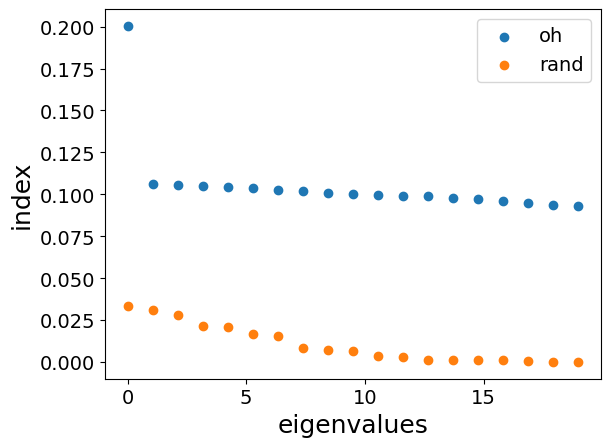

In [115]:
# np.linalg.solve(A)
plt.scatter(np.linspace(0,len(vals_oh),len(vals_oh)), vals_oh, label="oh")
plt.scatter(np.linspace(0,len(vals_rand),len(vals_rand)), vals_rand, label="rand")
# plt.scatter(np.linspace(0,len(vals_com),len(vals_com)), vals_com, label="com")
plt.xlabel("eigenvalues")
plt.ylabel("index")
plt.legend()


# A test of the Gram matrix of the one-hot representation #

In [73]:
import numpy as np

A = np.asarray(gram_oh)
fmt = np.vectorize(lambda x: f"{x:.1g}")  # tighten/loosen with .2g/.4g
S = fmt(A)

pad   = 0           # extra spaces added to each column width
sep   = " "         # spaces BETWEEN columns
align = "right"     # 'right', 'left', or 'center'
width = 4        # set to an int (e.g., 6) for fixed-width columns

# Compute per-column widths (or use a fixed width)
if width is None:
    w = [max(len(s) for s in col) + pad for col in S.T]
else:
    w = [width] * S.shape[1]

just = {"right": str.rjust, "left": str.ljust, "center": str.center}[align]

brL, brM, brR = "⎡", "⎢", "⎣"
brL2, brM2, brR2 = "⎤", "⎥", "⎦"
for i, row in enumerate(S):
    left  = brL if i == 0 else (brR if i == len(S)-1 else brM)
    right = brL2 if i == 0 else (brR2 if i == len(S)-1 else brM2)
    line = sep.join(just(s, wj) for s, wj in zip(row, w))
    print(f"{left} {line} {right}")


⎡  0.1    0    0    0    0    0    0    0    0    0 0.009 0.009 0.009 0.01 0.01 0.009 0.009 0.01 0.01 0.01 ⎤
⎢    0  0.1    0    0    0    0    0    0    0    0 0.01 0.009 0.01 0.008 0.01 0.01 0.01 0.01 0.01 0.01 ⎥
⎢    0    0  0.1    0    0    0    0    0    0    0 0.008 0.01 0.008 0.009 0.009 0.01 0.01 0.009 0.01 0.01 ⎥
⎢    0    0    0  0.1    0    0    0    0    0    0 0.01 0.01 0.009 0.01 0.01 0.009 0.009 0.01 0.01 0.01 ⎥
⎢    0    0    0    0  0.1    0    0    0    0    0 0.009 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 ⎥
⎢    0    0    0    0    0  0.1    0    0    0    0 0.009 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 ⎥
⎢    0    0    0    0    0    0  0.1    0    0    0 0.009 0.009 0.01 0.01 0.01 0.009 0.009 0.01 0.01 0.01 ⎥
⎢    0    0    0    0    0    0    0  0.1    0    0 0.01 0.01 0.009 0.01 0.01 0.01 0.01 0.01 0.01 0.01 ⎥
⎢    0    0    0    0    0    0    0    0  0.1    0 0.01 0.01 0.009 0.01 0.01 0.01 0.01 0.01 0.01 0.01 ⎥
⎢    0    0    0    0    0    0    0    0

## Compare numeric & analytic test losses - all representations ##

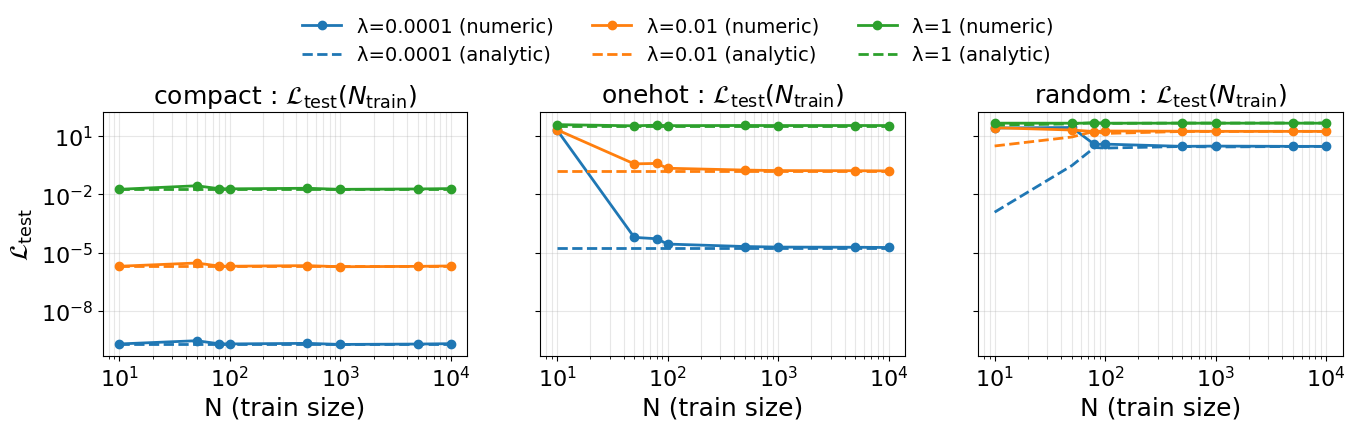

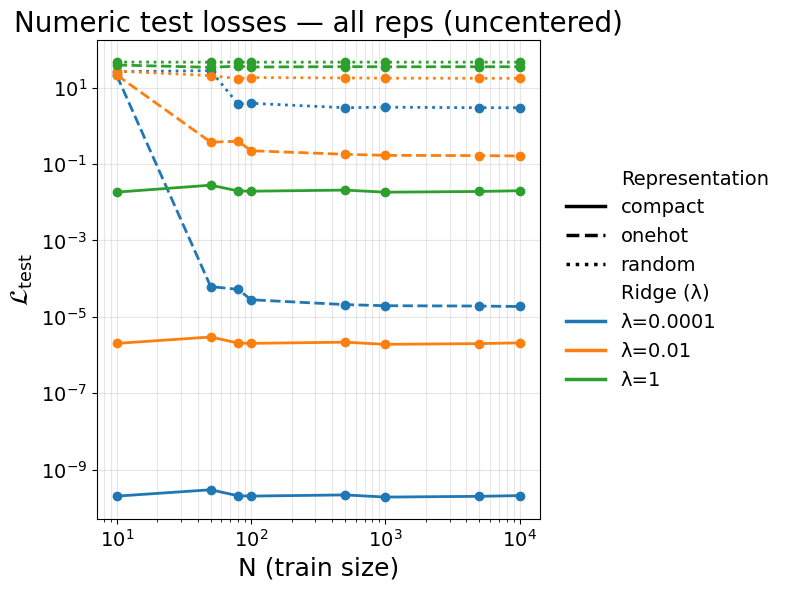

In [116]:
# task1_analytic_vs_numeric_uncentered.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------ grids ------------------
N_values = [10, 50, 80, 100, 500, 1_000, 5_000, 10_000]
lams = 10 ** np.linspace(np.log10(1e-4), np.log10(1), 3)

sim = AdditionRidgeTask(lams=lams, N_values=N_values, N_test=40_000, embed_dim=10)

reps = ["compact", "onehot", "random"]
center = "none"  # uncentered
fig, axes = plt.subplots(1, len(reps), figsize=(16, 4), sharey=True)
colors = sim.lam_color_map()

# cache numeric results for the comparison plot
num_all = {}

# ------------------ Figure 1: per-rep, vs N ------------------
for ax, rep in zip(axes, reps):
    # numeric
    num = sim.run_numeric(rep=rep, center=center)
    num_all[rep] = num  # save for later

    # analytic (if available)
    ana = sim.run_analytic(rep=rep, center=center)

    for lam in lams:
        lamf = float(lam)
        ax.plot(N_values, num[lamf], marker='o', lw=2.0, color=colors[lamf],
                label=f"λ={lamf:g} (numeric)")
        if ana is not None:
            ax.plot(N_values, ana[lamf], linestyle='--', lw=2.0, color=colors[lamf],
                    label=f"λ={lamf:g} (analytic)")

    ax.set_title(
        f"{rep} : $\\mathcal{{L}}_{{\\mathrm{{test}}}}(N_\\mathrm{{train}})$",
        fontsize=18
    )
    ax.set_xlabel("N (train size)", fontsize=18)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which='both', alpha=0.3)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

axes[0].set_ylabel(r"$\mathcal{L}_{\mathrm{test}}$", fontsize=18)

# global legend (dedup) and spacing
handles, labels = axes[0].get_legend_handles_labels()
uniq = dict(zip(labels, handles))
fig.legend(uniq.values(), uniq.keys(), loc="upper center",
           ncols=3, frameon=False, fontsize=14)
fig.subplots_adjust(top=0.72)  # leave room above subplots
# plt.savefig('Learning_Curves.pdf', bbox_inches='tight')


# -------------------------------------------------------------------------
# Figure 2: all reps together, numeric only  (like the attached screenshot)
# -------------------------------------------------------------------------


fig2, ax = plt.subplots(figsize=(8, 6))

# line styles per representation
rep_styles = {
    "compact": "-",
    "onehot": "--",
    "random": ":",
}

# plot numeric curves for each λ and rep
for lam in lams:
    lamf = float(lam)
    for rep in reps:
        y = num_all[rep][lamf]
        ax.plot(
            N_values,
            y,
            linestyle=rep_styles[rep],
            marker='o',
            lw=2.0,
            color=colors[lamf],
        )

ax.set_title("Numeric test losses — all reps (uncentered)", fontsize=20)
ax.set_xlabel("N (train size)", fontsize=18)
ax.set_ylabel(r"$\mathcal{L}_{\mathrm{test}}$", fontsize=18)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which='both', alpha=0.3)
ax.tick_params(axis='both', which='both', labelsize=14)

# ---------- custom legend: line style = rep, color = λ ----------
# Representation (line style) legend entries
rep_handles = [
    Line2D([0], [0], color="k", lw=2.5, linestyle=rep_styles["compact"]),
    Line2D([0], [0], color="k", lw=2.5, linestyle=rep_styles["onehot"]),
    Line2D([0], [0], color="k", lw=2.5, linestyle=rep_styles["random"]),
]
rep_labels = ["compact", "onehot", "random"]

# Ridge (λ) legend entries (colors from colors[λ])
lam_handles = [
    Line2D([0], [0], color=colors[float(lam)], lw=2.5)
    for lam in lams
]
lam_labels = [f"λ={float(lam):g}" for lam in lams]

# Combine into a single legend with two "sections"
handles = (
    [Line2D([], [], color="none")] +  # dummy for heading
    rep_handles +
    [Line2D([], [], color="none")] +
    lam_handles
)
labels = (
    ["Representation"] +
    rep_labels +
    ["Ridge (λ)"] +
    lam_labels
)

ax.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=14,
)

fig2.tight_layout()
plt.savefig("Numeric_test_losses_all_reps_uncentered.pdf", bbox_inches="tight")
plt.show()





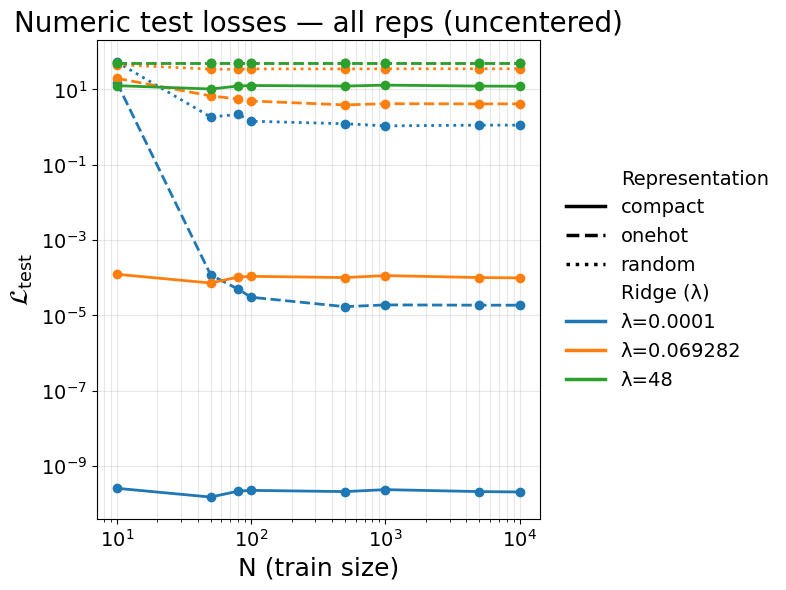

# $\mathcal{L}_{\text{test}}(\lambda)$ for each representation #

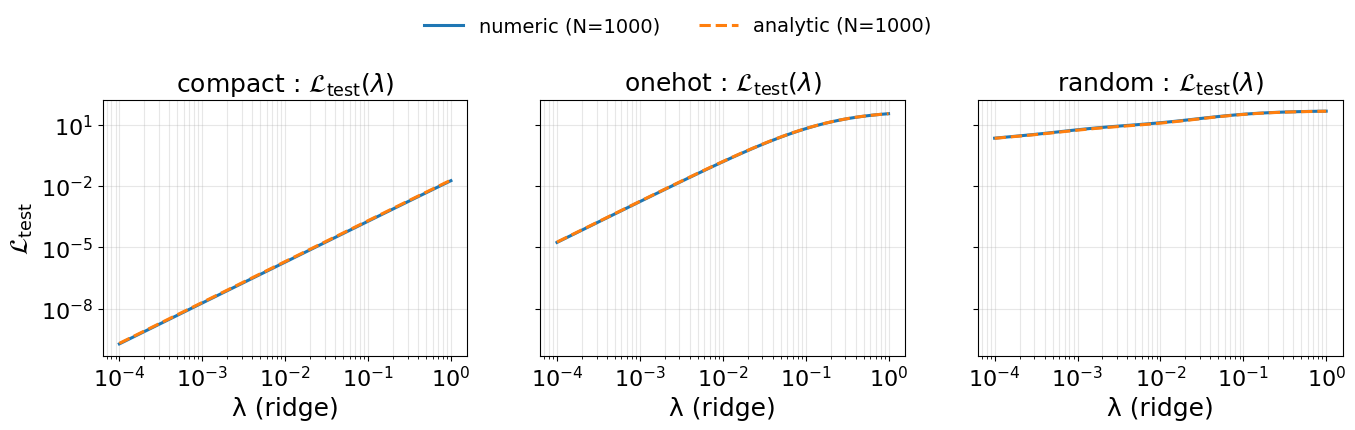

In [75]:
# ------------------ Figure 3: test loss vs λ (dense λ sweep, N=1000) ------------------
lam_min, lam_max = float(lams.min()), float(lams.max())
lams_dense = 10 ** np.linspace(np.log10(lam_min), np.log10(lam_max), 60)

# fresh simulator only for this λ-sweep plot
sim_lamsweep = AdditionRidgeTask(
    lams=lams_dense, N_values=N_values, N_test=40_000, seed=123, embed_dim=10
)

N_fixed = 1000
N_idx = int(np.where(np.array(N_values) == N_fixed)[0][0])

fig3, axes3 = plt.subplots(1, len(reps), figsize=(16, 4), sharey=True)

for ax, rep in zip(axes3, reps):
    num_dense = sim_lamsweep.run_numeric(rep=rep, center=center)      # dict: λ -> losses over N_values
    ana_dense = sim_lamsweep.run_analytic(rep=rep, center=center)     # may be None

    # numeric curve at fixed N
    y_num = np.array([num_dense[float(l)][N_idx] for l in lams_dense])
    line_num, = ax.plot(lams_dense, y_num, lw=2.2, label=f"numeric (N={N_fixed})")

    # analytic curve at fixed N (if available)
    if ana_dense is not None:
        y_ana = np.array([ana_dense[float(l)][N_idx] for l in lams_dense])
        line_ana, = ax.plot(lams_dense, y_ana, lw=2.2, linestyle='--',
                            label=f"analytic (N={N_fixed})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", alpha=0.3)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("λ (ridge)", fontsize=18)
    ax.set_title(f"{rep} : $\\mathcal{{L}}_{{\\mathrm{{test}}}}(\\lambda)$", fontsize=18)

axes3[0].set_ylabel(r"$\mathcal{L}_{\mathrm{test}}$", fontsize=18)

# shared legend for numeric vs analytic
handles3, labels3 = axes3[0].get_legend_handles_labels()
uniq3 = dict(zip(labels3, handles3))
fig3.legend(uniq3.values(), uniq3.keys(), loc="upper center",
            ncols=2, frameon=False, fontsize=14)
fig3.subplots_adjust(top=0.75)
plt.savefig('Test_loss_ridge_dependence.pdf', bbox_inches='tight')
plt.show()


# A plot of the numeric test and the Shrinkage factor of each representation - negative correlation between the two #

[1.5748529671589824e-09, 1.4828295005808952e-09, 1.2904954930279552e-09, 1.3657228747790828e-09, 1.4652477901621685e-09, 1.473163301692092e-09, 1.4352378909459766e-09, 1.4175406851539843e-09]
[5.457954612017562e-07, 3.1107528444363676e-06, 2.5105778601763886e-06, 2.3270499457547467e-06, 1.9053153083334727e-06, 1.874207351884882e-06, 1.8525225572357467e-06, 1.8502955479695062e-06]
[1.3122733540041491e-05, 9.271698625000609e-05, 9.8707242780813e-05, 9.088087837801164e-05, 8.866461940528949e-05, 8.766100007726635e-05, 8.719514297962365e-05, 8.74751270288832e-05]


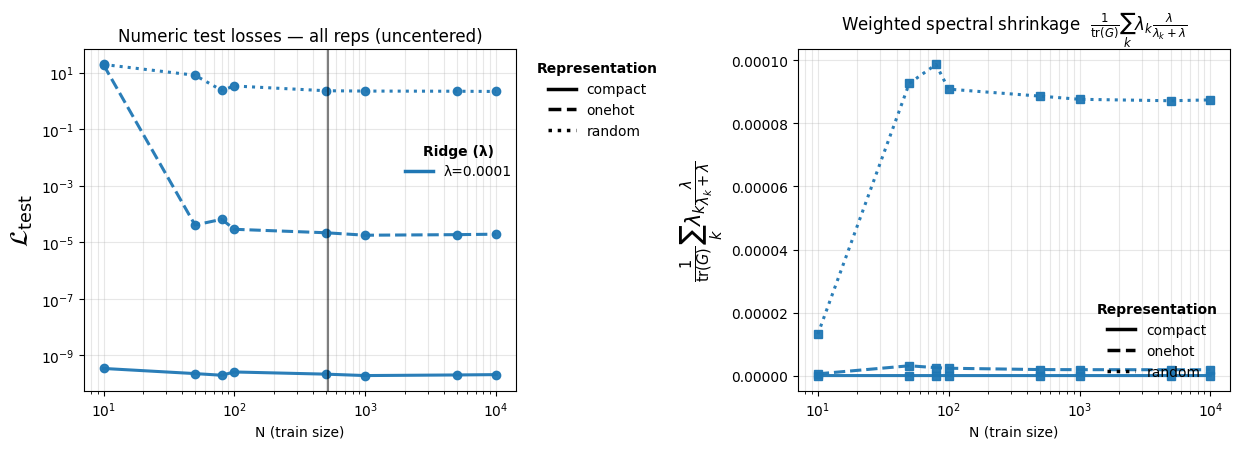

In [76]:
# ============================ EXPERIMENT & PLOTS ==============================
# grids
N_values = [10, 50, 80, 100, 500, 1_000, 5_000, 10_000]
lams = 10 ** np.linspace(np.log10(1e-4), np.log10(1.0), 1)

# simulator
sim = AdditionRidgeTask(lams=lams, N_values=N_values, N_test=40_000, seed=123, embed_dim=10)

# which reps and centering?
reps = ["compact", "onehot", "random"]
center_mode = "none"  # uncentered, matches your title

# run numeric to populate artifacts and losses
num_all: Dict[str, Dict[float, List[float]]] = {}
for rep in reps:
    num_all[rep] = sim.run_numeric(rep, center=center_mode, use_intercept=False, penalize_intercept=False)

# colors per λ (consistent across both panels)
colors = sim.lam_color_map()

# ------------------ Figure 2: loss (left) + effective dimension (right) ------
fig2, (ax_loss, ax_deff) = plt.subplots(1, 2, figsize=(12.5, 4.6), sharex=True)
linestyles = {"compact": "-", "onehot": "--", "random": ":"}
lams_for_plot = lams  # plot all λ curves

# Left: numeric test losses
for lam in lams_for_plot:
    lamf = float(lam)
    for rep in reps:
        ax_loss.plot(
            N_values,
            num_all[rep][lamf],
            marker='o',
            lw=2.2,
            linestyle=linestyles[rep],
            color=colors[lamf],
            alpha=0.95,
        )

lambda_legend = [
    Line2D([0], [0], color=colors[float(l)], lw=2.5, label=f"λ={float(l):g}")
    for l in lams_for_plot
]
rep_legend = [
    Line2D([0], [0], color='k', lw=2.5, linestyle=linestyles[r], label=r)
    for r in reps
]

leg1 = ax_loss.legend(handles=lambda_legend, title="Ridge (λ)", frameon=False, bbox_to_anchor=(1.02, 0.76))
leg1.set_title("Ridge (λ)", prop={'weight': 'bold'})
ax_loss.add_artist(leg1)
leg2 = ax_loss.legend(handles=rep_legend, title="Representation", frameon=False, bbox_to_anchor=(1.02, 1.00))
leg2.set_title("Representation", prop={'weight': 'bold'})

ax_loss.set_title("Numeric test losses — all reps (uncentered)")
ax_loss.set_xlabel("N (train size)")
ax_loss.set_ylabel(r"$\mathcal{L}_{\mathrm{test}}$", fontsize=18)
ax_loss.set_xscale("log")
ax_loss.set_yscale("log")
ax_loss.axvline(x=518, linestyle="-", color="k", alpha=0.5)
ax_loss.grid(True, which='both', alpha=0.3)


# ---------- RIGHT PANEL: weighted spectral shrinkage (unsquared), per-trace ---
def _weighted_shrinkage_per_trace(sim, rep, center, N, lam):
    """
    (1/trace(G)) * sum_k λ_k * [λ/(λ_k + λ)], with G=(1/N) F^T F (no intercept).
    """
    art = sim.get_artifacts(rep, center, N)
    evals = np.asarray(art.eig_F_vals, dtype=float)  # eigs of (1/N)F^T F
    if evals.size == 0:
        return np.nan
    lam = float(lam)
    trG = float(evals.sum())
    if trG <= 0.0:
        return 0.0
    factors = lam / (evals + lam)  # no square
    return float(np.sum(evals * factors ** 2))

# clear the right axes (the one you created above)
ax_deff.cla()

# plot on ax_deff (NOT ax_omdeff)
for lam in lams_for_plot:
    lamf = float(lam)
    for rep in reps:
        ws_curve = [
            _weighted_shrinkage_per_trace(sim, rep, center_mode, int(N), lamf)
            for N in N_values
        ]
        print(ws_curve)
        ax_deff.plot(
            N_values, ws_curve,
            marker='s', lw=2.2,
            linestyle=linestyles[rep],
            color=colors[lamf], alpha=0.95,
        )

# legend on the right axes
rep_legend_right = [
    Line2D([0], [0], color='k', lw=2.5, linestyle=linestyles[r], label=r)
    for r in reps
]
legR = ax_deff.legend(handles=rep_legend_right, title="Representation",
                      frameon=False, loc="lower right")
legR.set_title("Representation", prop={'weight': 'bold'})

ax_deff.set_title(r"Weighted spectral shrinkage  $\frac{1}{\mathrm{tr}(G)}\sum_k \lambda_k \frac{\lambda}{\lambda_k+\lambda}$")
ax_deff.set_xlabel("N (train size)")
ax_deff.set_ylabel(r"$\frac{1}{\mathrm{tr}(G)}\sum_k \lambda_k \frac{\lambda}{\lambda_k+\lambda}$", fontsize=15)
ax_deff.set_xscale("log")
# ax_deff.set_ylim(0.0, 1.02)
ax_deff.grid(True, which='both', alpha=0.3)

fig2.tight_layout()
plt.show()


# The alignment of each representation : $u_k^Tw_{\text{true}}$ (from the overleaf)#

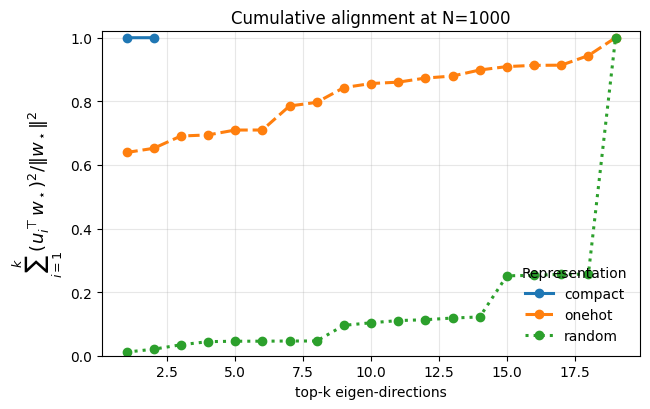

In [46]:
# ---------------- Optional: cumulative alignment vs top-k (at a chosen N) ---

# Colors per representation (must match: "compact", "onehot", "random")
rep_colors = {
    "compact": plt.cm.tab10(0),
    "onehot":  plt.cm.tab10(1),
    "random":  plt.cm.tab10(2),
}


N_sel = 1000  # pick one train size to inspect
figB, axB = plt.subplots(figsize=(6.6, 4.2))

for rep in reps:
    cum = sim.alignment_curve(rep, center_mode, N_sel, normalize=True, with_bias_eigs=True)
    axB.plot(
        np.arange(1, cum.size + 1), cum,
        lw=2.2, marker="o",
        linestyle=linestyles[rep],
        color=rep_colors[rep],
        label=rep
    )

axB.set_title(f"Cumulative alignment at N={N_sel}")
axB.set_xlabel("top-k eigen-directions")
axB.set_ylabel(r"$\sum_{i=1}^{k}(u_i^\top w_\star)^2/\|w_\star\|^2$", fontsize=13)
axB.set_ylim(0.0, 1.02)
axB.grid(True, which="both", alpha=0.3)
axB.legend(title="Representation", frameon=False, loc="lower right")
figB.tight_layout()
plt.savefig(f"Cumulative_alignment_N{N_sel}.pdf", bbox_inches="tight")
plt.show()


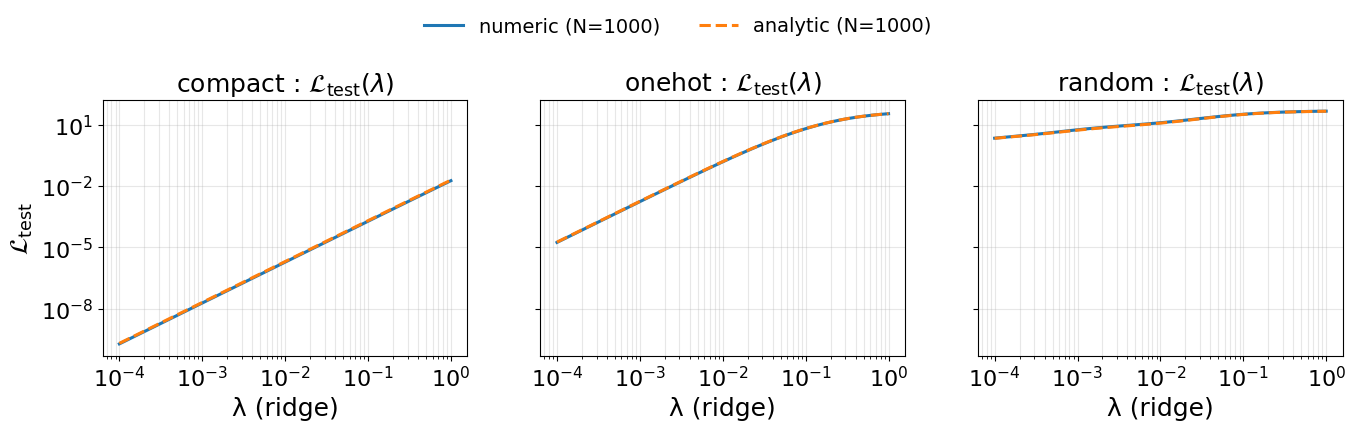

# Simulating how many samples cover all 100 uniformly distributed options #

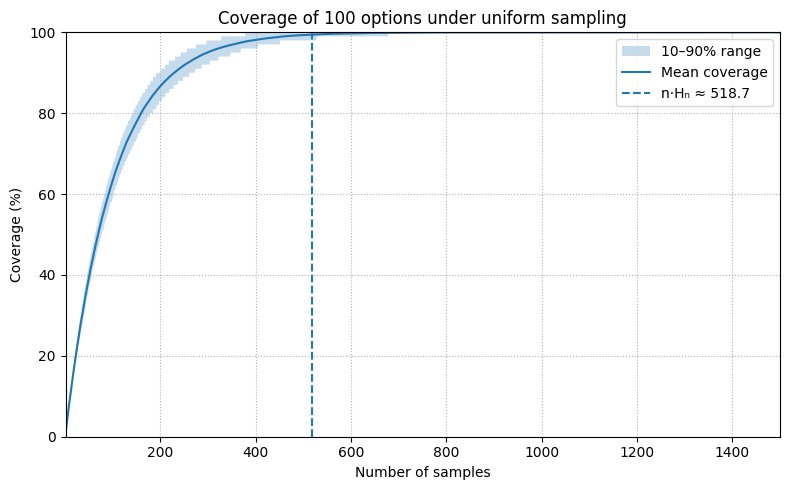

Expected samples to hit 100% (n·Hₙ):  518.7
Share of trials reaching 100% by 1500 samples: 100.0%
Median/Mean time to 100% (for reached trials): 498 / 514.2 samples
10–90% interval of time to 100%: 377–677 samples


In [8]:
# Coupon Collector Simulation: coverage vs. number of samples
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters (feel free to tweak and re-run) ----
n_options   = 100         # number of categories/options
num_trials  = 1000        # how many Monte Carlo trials
max_samples = 1500        # simulate up to this many samples per trial
rng_seed    = 42          # reproducibility

rng = np.random.default_rng(rng_seed)

# Storage for coverage curves (fraction in [0,1])
coverage_curves = np.empty((num_trials, max_samples), dtype=float)

# Also store the time (index) each trial first reaches full coverage, if it does
time_to_full = np.full(num_trials, max_samples, dtype=int)  # censored at max_samples

for t in range(num_trials):
    draws = rng.integers(low=0, high=n_options, size=max_samples)
    # first occurrence index for each option via reduction
    first_occ = np.full(n_options, max_samples, dtype=int)
    np.minimum.at(first_occ, draws, np.arange(max_samples))

    # Coverage curve: how many options seen by each step k
    sorted_occ = np.sort(first_occ)  # length n_options
    ks = np.arange(max_samples)
    covered_counts = np.searchsorted(sorted_occ, ks, side='right')  # number <= k
    coverage_curves[t] = covered_counts / n_options

    # When (if) full coverage occurs (i.e., all first_occ < max_samples)
    if sorted_occ[-1] < max_samples:
        time_to_full[t] = sorted_occ[-1]

# Aggregate stats across trials
mean_coverage = coverage_curves.mean(axis=0)
q10 = np.quantile(coverage_curves, 0.10, axis=0)
q90 = np.quantile(coverage_curves, 0.90, axis=0)

# Coupon collector expected time ~ n * H_n
H_n = np.sum(1.0 / np.arange(1, n_options + 1))
expected_full = n_options * H_n

# Empirical stats (only for trials that reached full coverage)
reached_mask = time_to_full < max_samples
reached_times = time_to_full[reached_mask]
share_reached = reached_mask.mean()

# ---- Plot ----
plt.figure(figsize=(8, 5))
x = np.arange(1, max_samples + 1)
plt.fill_between(x, q10 * 100, q90 * 100, alpha=0.25, label="10–90% range")
plt.plot(x, mean_coverage * 100, label="Mean coverage")
plt.axvline(expected_full, linestyle="--", label=f"n·Hₙ ≈ {expected_full:.1f}")
plt.xlabel("Number of samples")
plt.ylabel("Coverage (%)")
plt.ylim(0, 100)
plt.xlim(1, max_samples)
plt.title(f"Coverage of {n_options} options under uniform sampling")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.savefig('Uniform_dist_coverage.pdf', bbox_inches='tight')
plt.show()

# ---- Print a few summary stats ----
print(f"Expected samples to hit 100% (n·Hₙ):  {expected_full:.1f}")
print(f"Share of trials reaching 100% by {max_samples} samples: {share_reached*100:.1f}%")
if reached_times.size > 0:
    print(f"Median/Mean time to 100% (for reached trials): "
          f"{np.median(reached_times):.0f} / {np.mean(reached_times):.1f} samples")
    p10 = np.quantile(reached_times, 0.10)
    p90 = np.quantile(reached_times, 0.90)
    print(f"10–90% interval of time to 100%: {p10:.0f}–{p90:.0f} samples")


# A Test to show that when the random rep's performance depends on normalization #

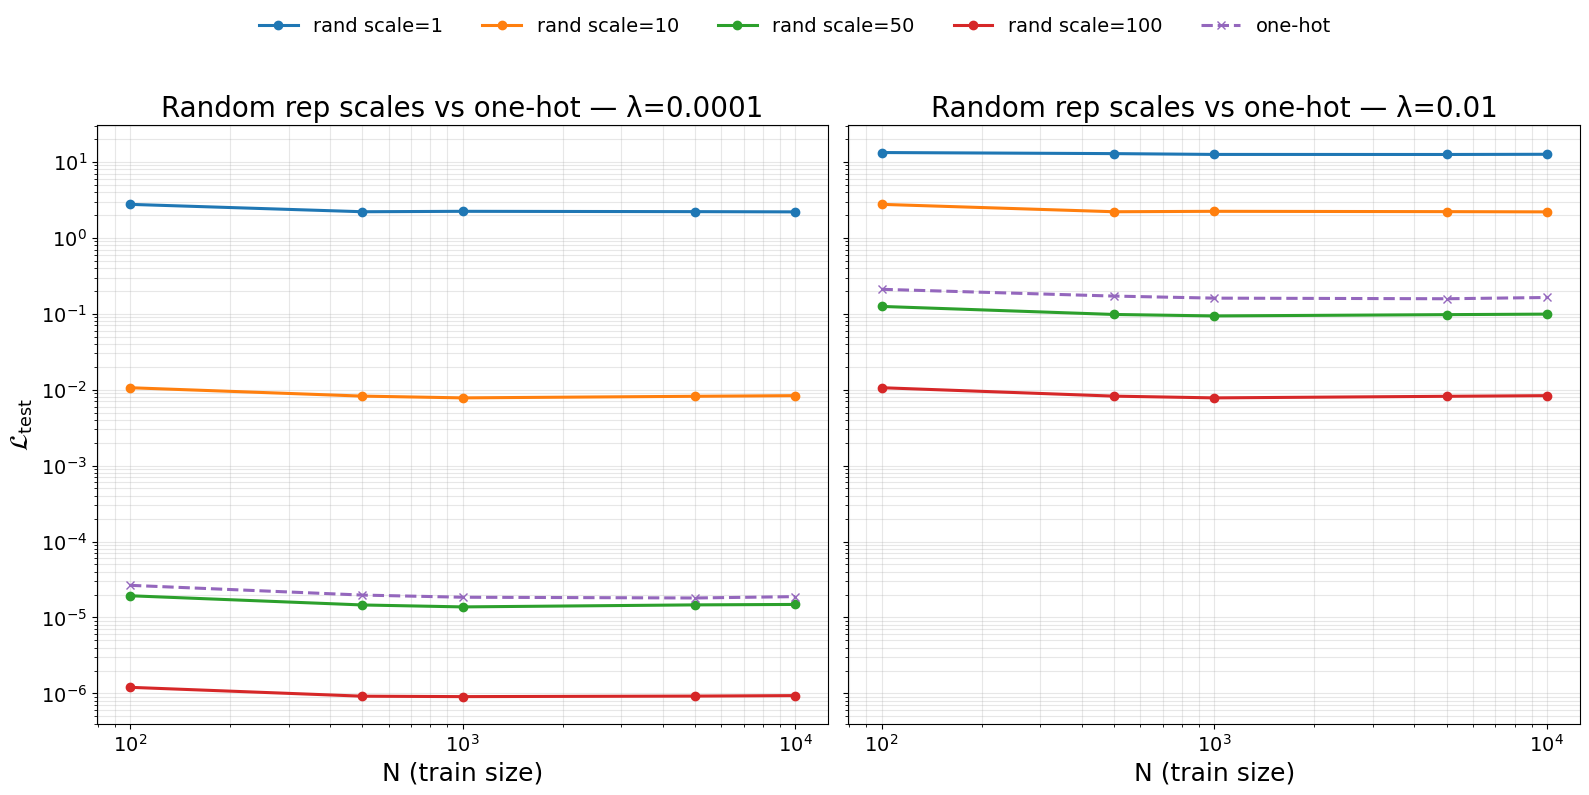

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# --- global fontsize settings ---
plt.rcParams.update({
    "axes.titlesize": 20,   # subplot titles
    "axes.labelsize": 18,   # x/y labels
    "xtick.labelsize": 14,  # x tick labels
    "ytick.labelsize": 14,  # y tick labels
    "legend.fontsize": 14,  # legend text
})

# Ensure class exists
try:
    AdditionRidgeTask
except NameError as e:
    raise RuntimeError("AdditionRidgeTask is not defined in this notebook session.") from e

# Config
lams = 10 ** np.linspace(np.log10(1e-4), np.log10(1e-2), 2)
N_values = [100, 500, 1000, 5000, 10000]
embed_dim = 10
seed = 123
center = "none"
scales = [1, 10, 50, 100]

# Optional palette keyed by λ (unused in this snippet, but fine to keep)
sim_palette = AdditionRidgeTask(lams=lams, N_values=N_values, N_test=40_000, seed=seed, embed_dim=embed_dim)
colors = sim_palette.lam_color_map()

# Compute numeric curves for each random variance
num_random = {}
for s in scales:
    sim = AdditionRidgeTask(
        lams=lams, N_values=N_values, N_test=40_000,
        seed=seed, embed_dim=embed_dim, scale=s
    )
    num_random[s] = sim.run_numeric(rep="random", center=center)

# One-hot baseline (single run)
sim_oh = AdditionRidgeTask(lams=lams, N_values=N_values, N_test=40_000, seed=seed, embed_dim=embed_dim)
num_onehot = sim_oh.run_numeric(rep="onehot", center=center)

# Plot: 3 panels (one per λ), lines = random variances + one-hot
fig, axes = plt.subplots(1, len(lams), figsize=(16, 8), sharey=True)

for ax, lam in zip(axes, lams):
    lamf = float(lam)
    # Random variances
    for s in scales:
        y = num_random[s][lamf]
        ax.plot(N_values, y, marker='o', lw=2.2, label=f"rand scale={s:g}")
    # One-hot reference
    y_oh = num_onehot[lamf]
    ax.plot(N_values, y_oh, linestyle='--', marker='x', lw=2.2, label="one-hot")

    ax.set_title(f"Random rep scales vs one-hot — λ={lamf:g}")
    ax.set_xlabel("N (train size)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which='both', alpha=0.3)

    # Larger tick labels (redundant with rcParams, but explicit if you like)
    ax.tick_params(axis='both', which='both', labelsize=14)

axes[0].set_ylabel(r"$\mathcal{L}_{\text{test}}$")

# Single legend across figure
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncols=len(scales) + 1, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig('Random_rep_scales_vs_onehot.pdf', bbox_inches='tight')
plt.show()


In [82]:
scales

array([1.00000000e+00, 2.15443469e+01, 4.64158883e+02, 1.00000000e+04])

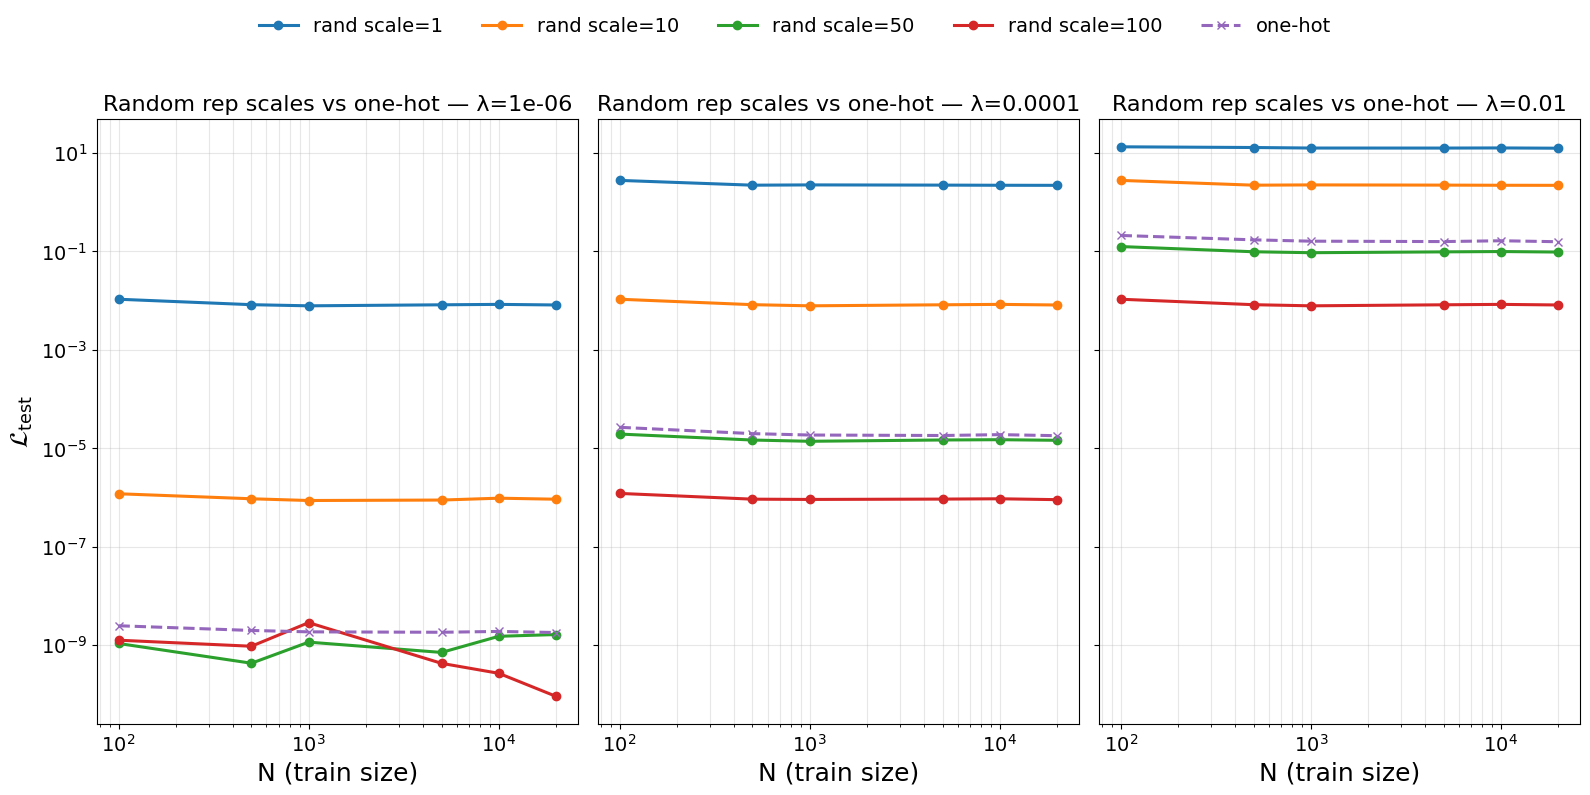

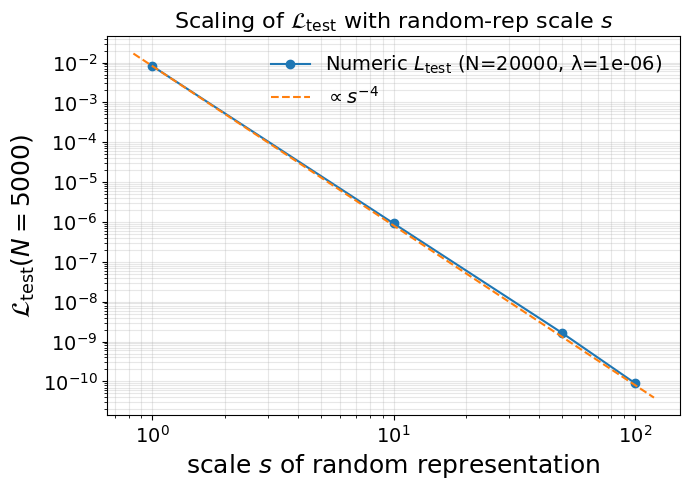

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# --- global fontsize settings ---
plt.rcParams.update({
    "axes.titlesize": 16,   # subplot titles
    "axes.labelsize": 18,   # x/y labels
    "xtick.labelsize": 14,  # x tick labels
    "ytick.labelsize": 14,  # y tick labels
    "legend.fontsize": 14,  # legend text
})

# Ensure class exists
try:
    AdditionRidgeTask
except NameError as e:
    raise RuntimeError("AdditionRidgeTask is not defined in this notebook session.") from e

# Config
lams = 10 ** np.linspace(np.log10(1e-6), np.log10(1e-2), 3)
N_values = [100, 500, 1000, 5000, 10000, 20000]
embed_dim = 10
seed = 123
center = "none"
scales = [1, 10, 50, 100]

# Optional palette keyed by λ (unused here, but fine to keep)
sim_palette = AdditionRidgeTask(
    lams=lams, N_values=N_values, N_test=40_000,
    seed=seed, embed_dim=embed_dim
)
colors = sim_palette.lam_color_map()

# Compute numeric curves for each random variance
num_random = {}
for s in scales:
    sim = AdditionRidgeTask(
        lams=lams, N_values=N_values, N_test=40_000,
        seed=seed, embed_dim=embed_dim, scale=s
    )
    num_random[s] = sim.run_numeric(rep="random", center=center)

# One-hot baseline (single run)
sim_oh = AdditionRidgeTask(
    lams=lams, N_values=N_values, N_test=40_000,
    seed=seed, embed_dim=embed_dim
)
num_onehot = sim_oh.run_numeric(rep="onehot", center=center)

# ===================== FIGURE 1: curves vs N for each λ =======================
fig, axes = plt.subplots(1, len(lams), figsize=(16, 8), sharey=True)

for ax, lam in zip(axes, lams):
    lamf = float(lam)
    # Random variances
    for s in scales:
        y = num_random[s][lamf]
        ax.plot(N_values, y, marker='o', lw=2.2, label=f"rand scale={s:g}")
    # One-hot reference
    y_oh = num_onehot[lamf]
    ax.plot(N_values, y_oh, linestyle='--', marker='x', lw=2.2, label="one-hot")

    ax.set_title(f"Random rep scales vs one-hot — λ={lamf:g}")
    ax.set_xlabel("N (train size)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which='both', alpha=0.3)
    ax.tick_params(axis='both', which='both', labelsize=14)

axes[0].set_ylabel(r"$\mathcal{L}_{\text{test}}$")

# Single legend across figure
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncols=len(scales) + 1, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig('Random_rep_scales_vs_onehot.pdf', bbox_inches='tight')
plt.show()

# ===================== FIGURE 2: L_test vs s at fixed N ======================
# Fix N and λ for the scaling test
N_target = 20000
idx_N = N_values.index(N_target)
lam_ref = float(lams[0])   # you can change to lams[1] if you prefer

# Collect numeric L_test for each scale at this N, λ
s_vals = np.array(scales, dtype=float)
L_vals = np.array([num_random[s][lam_ref][idx_N] for s in scales])

# Sort by s just to make the curve nice
order = np.argsort(s_vals)
s_vals = s_vals[order]
L_vals = L_vals[order]

plt.figure(figsize=(7, 5))
plt.loglog(s_vals, L_vals, 'o-', label=rf'Numeric $L_{{\text{{test}}}}$ (N={N_target}, λ={lam_ref:g})')

# Theoretical ~ 1/s^4 curve, normalized to match the first data point
A = L_vals[0] * (s_vals[0]**4)     # so that A / s0^4 = L0
s_fine = np.logspace(np.log10(s_vals.min()/1.2), np.log10(s_vals.max()*1.2), 200)
L_model = A / (s_fine**4)

plt.loglog(s_fine, L_model, '--', label=r'$\propto s^{-4}$')

plt.xlabel("scale $s$ of random representation")
plt.ylabel(r"$\mathcal{L}_{\text{test}}(N=5000)$")
plt.title(r"Scaling of $\mathcal{L}_{\text{test}}$ with random-rep scale $s$")
plt.grid(True, which='both', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Ltest_vs_scale_s.pdf', bbox_inches='tight')
plt.show()


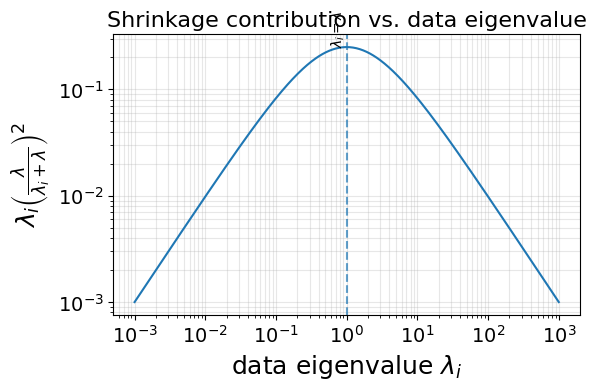

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# ----- parameters -----
lam = 1.0  # ridge parameter λ (you can change this)

# λ_i grid: from 10^-3 * λ to 10^3 * λ
lam_i = lam * np.logspace(-3, 3, 500)

# define the function: λ_i * (λ / (λ_i + λ))^2
def shrinkage_term(lam_i, lam):
    return lam_i * (lam / (lam_i + lam))**2

f_vals = shrinkage_term(lam_i, lam)

# ----- plot -----
fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(lam_i, f_vals)

# mark λ_i = λ
ax.axvline(lam, linestyle="--", alpha=0.7)
ax.text(lam, f_vals[np.argmin(np.abs(lam_i - lam))],
        r"$\lambda_i = \lambda$", rotation=90,
        va="bottom", ha="right")

ax.set_xlabel(r"data eigenvalue $\lambda_i$")
ax.set_ylabel(r"$\lambda_i \left(\frac{\lambda}{\lambda_i + \lambda}\right)^2$")
ax.set_title(r"Shrinkage contribution vs. data eigenvalue")
ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()
